In [1]:
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import load_model
import joblib



In [2]:
stock_symbol = 'MSFT' #place the stock symbol


df = pd.read_csv(f'stock_datasets/{stock_symbol}_daily_data.csv')
print(df.head())
print(df.shape)

                        Date      Open      High       Low     Close  \
0  1986-03-13 00:00:00-05:00  0.054594  0.062623  0.054594  0.059946   
1  1986-03-14 00:00:00-05:00  0.059947  0.063158  0.059947  0.062087   
2  1986-03-17 00:00:00-05:00  0.062087  0.063694  0.062087  0.063158   
3  1986-03-18 00:00:00-05:00  0.063158  0.063694  0.061017  0.061552   
4  1986-03-19 00:00:00-05:00  0.061552  0.062087  0.059946  0.060482   

       Volume  Dividends  Stock Splits Symbol  
0  1031788800        0.0           0.0   MSFT  
1   308160000        0.0           0.0   MSFT  
2   133171200        0.0           0.0   MSFT  
3    67766400        0.0           0.0   MSFT  
4    47894400        0.0           0.0   MSFT  
(9744, 9)


In [3]:
symbol = df['Symbol'].unique()[0]
print(symbol)

MSFT


In [4]:
print(df.isna().sum())
df = df.dropna()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Symbol          0
dtype: int64


In [5]:

df.drop(columns=['Dividends', 'Stock Splits', 'Symbol'], inplace=True) #these columns won't be needed for forecasts


#for testing purposes let's only consider historical data for the moment
#df = df[['Date', 'Close']]   

df.head()




,Date,Open,High,Low,Close,Volume
0,1986-03-13 00:00:00-05:00,0.054594,0.062623,0.054594,0.059946,1031788800
1,1986-03-14 00:00:00-05:00,0.059947,0.063158,0.059947,0.062087,308160000
2,1986-03-17 00:00:00-05:00,0.062087,0.063694,0.062087,0.063158,133171200
3,1986-03-18 00:00:00-05:00,0.063158,0.063694,0.061017,0.061552,67766400
4,1986-03-19 00:00:00-05:00,0.061552,0.062087,0.059946,0.060482,47894400


In [6]:
#change date

# Ensure the 'Date' column is of string type
df['Date'] = df['Date'].astype(str)

# Now, slice the string to get just the 'YYYY-MM-DD' part
df['Date'] = df['Date'].str[:10]

df['Date'] = pd.to_datetime(df['Date'])
print(df['Date'])
df.set_index('Date', inplace=True )
df.head()


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9739   2024-11-04
9740   2024-11-05
9741   2024-11-06
9742   2024-11-07
9743   2024-11-08
Name: Date, Length: 9744, dtype: datetime64[ns]


,Open,High,Low,Close,Volume
Date,,,,,
1986-03-13,0.054594,0.062623,0.054594,0.059946,1031788800
1986-03-14,0.059947,0.063158,0.059947,0.062087,308160000
1986-03-17,0.062087,0.063694,0.062087,0.063158,133171200
1986-03-18,0.063158,0.063694,0.061017,0.061552,67766400
1986-03-19,0.061552,0.062087,0.059946,0.060482,47894400


In [7]:
fig = px.line(df, x=df.index, y=df['Close'], title=f'Stock prices over time for stock {symbol}')
fig.show()

# Forecasting

In [8]:
#while we're still creating the lstm model, let's use a subset of our dataset



#df_testing = df.loc['2000-01-01':]
df_testing = df
df_testing.shape

(9744, 5)

In [9]:
#train/test split

n = len(df_testing)
training_data = df_testing[0:int(n*0.7)]
validation_data = df_testing[int(n*0.7):int(n*0.9)]
test_data = df_testing[int(n*0.9):]



In [10]:
def df_to_X_Y(df, window_size=8):
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][3]
        Y.append(label)
    return np.array(X), np.array(Y)

In [11]:
#df_testing = df_testing[['Close']]
X, Y = df_to_X_Y(df_testing)
X.shape, Y.shape

((9736, 8, 5), (9736,))

In [12]:
n = len(df_testing)
threshold = 0.9

X_train, Y_train = X[:int(n*threshold)], Y[:int(n*threshold)]
X_test, Y_test = X[int(n*threshold):], Y[int(n*threshold):]



In [13]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape


((8769, 8, 5), (8769,), (967, 8, 5), (967,))

In [14]:
# Initialize scalers
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
Y_train_scaled = scaler_Y.fit_transform(Y_train.reshape(-1, 1))



X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
Y_test_scaled = scaler_Y.transform(Y_test.reshape(-1, 1))

In [15]:
# Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    LSTM(100, return_sequences=False),
    Dense(50, activation='relu'),  # Add a Dense layer for complexity
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train the model
history = model.fit(
    X_train_scaled, Y_train_scaled,
    epochs=40,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

c:\Users\João\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0034
Epoch 2/40
  5/275 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 9.4416e-05 

c:\Users\João\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



275/275 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 6.4411e-05
Epoch 3/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.8854e-05
Epoch 4/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.6286e-05
Epoch 5/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.8128e-05
Epoch 6/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.4980e-05
Epoch 7/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 5.4685e-05
Epoch 8/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.0220e-05
Epoch 9/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.9489e-05
Epoch 10/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.7971e-05
Epoch 11/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.2544e-05
Epoch 12/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.8189e-05
Epoch 13/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.5421e-05
Epoch 14/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.8072e-05
Epoch 15/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.9152e-

In [16]:
# Predict on the test set
Y_test_pred_scaled = model.predict(X_test_scaled)

# Inverse transform predictions and actual values to the original scale
Y_test_pred = scaler_Y.inverse_transform(Y_test_pred_scaled)
Y_test_original = scaler_Y.inverse_transform(Y_test_scaled)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_test_pred))
mae = mean_absolute_error(Y_test_original, Y_test_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 8.422053476351094
MAE: 6.422426131050248


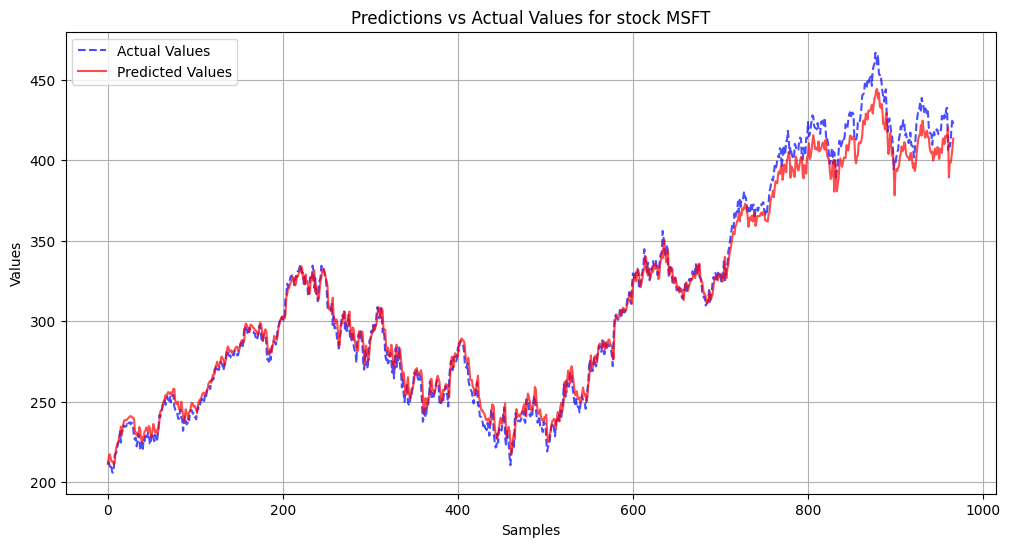

In [18]:
# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(Y_test_original, label="Actual Values", linestyle='--', color='blue', alpha=0.7)
plt.plot(Y_test_pred, label="Predicted Values", color='red', alpha=0.7)
plt.title(f"Predictions vs Actual Values for stock {stock_symbol}")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

# Future predictions


Epoch 1/40


c:\Users\João\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0053
Epoch 2/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7.6805e-05
Epoch 3/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7.1593e-05
Epoch 4/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.6623e-05
Epoch 5/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.0646e-05
Epoch 6/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.3965e-05
Epoch 7/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.2493e-05
Epoch 8/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.5603e-05
Epoch 9/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.9949e-05
Epoch 10/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.9310e-05
Epoch 11/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 6.9259e-05
Epoch 12/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 5.3262e-05
Epoch 13/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 5.1256e-05
Epoch 14/40
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.1718e-05
Ep

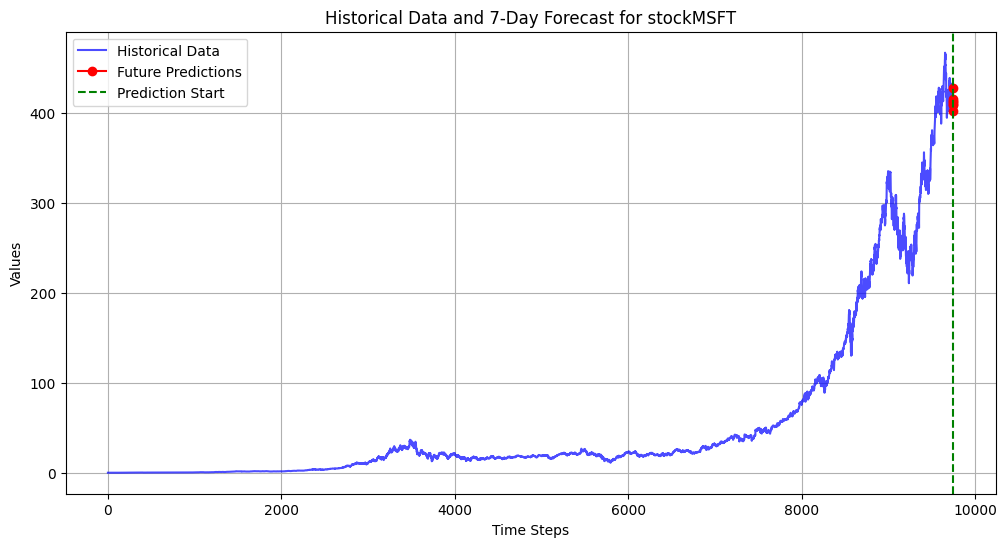

['models/scaler_Y.pkl']

In [19]:
# Use the entire dataset for training
X_full, Y_full = df_to_X_Y(df_testing)

# Scale the entire dataset
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_full_scaled = scaler_X.fit_transform(X_full.reshape(-1, X_full.shape[2])).reshape(X_full.shape)
Y_full_scaled = scaler_Y.fit_transform(Y_full.reshape(-1, 1))

# Train the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_full_scaled.shape[1], X_full_scaled.shape[2])),
    LSTM(100, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Train using the full dataset
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(X_full_scaled, Y_full_scaled, epochs=40, batch_size=32, callbacks=[early_stopping], verbose=1)

# Predict 7 days into the future
last_window = X_full_scaled[-1]  # Last window for starting the prediction
future_predictions_scaled = []

for _ in range(7):  # Predict for 7 days
    last_window_batch = np.expand_dims(last_window, axis=0)  # Add batch dimension
    next_prediction_scaled = model.predict(last_window_batch)[0][0]
    future_predictions_scaled.append(next_prediction_scaled)
    next_row = last_window[-1].copy()  # Copy the last row
    next_row[-1] = next_prediction_scaled  # Update with the predicted value
    last_window = np.vstack([last_window[1:], next_row])  # Slide the window

# Inverse transform the predictions
future_predictions = scaler_Y.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Combine historical data and future predictions
historical_data = df_testing['Close'].values  # Original 'Close' column
future_time_steps = range(len(historical_data), len(historical_data) + 7)  # Future time indices

# Plot historical data and future predictions
plt.figure(figsize=(12, 6))
plt.plot(historical_data, label='Historical Data', color='blue', alpha=0.7)
plt.plot(future_time_steps, future_predictions, label='Future Predictions', color='red', marker='o')
plt.axvline(x=len(historical_data)-1, color='green', linestyle='--', label='Prediction Start')
plt.title(f"Historical Data and 7-Day Forecast for stock{stock_symbol}")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

# Save the model
model.save("models/lstm_stock_model.h5")

# Save the scalers
joblib.dump(scaler_X, "models/scaler_X.pkl")
joblib.dump(scaler_Y, "models/scaler_Y.pkl")




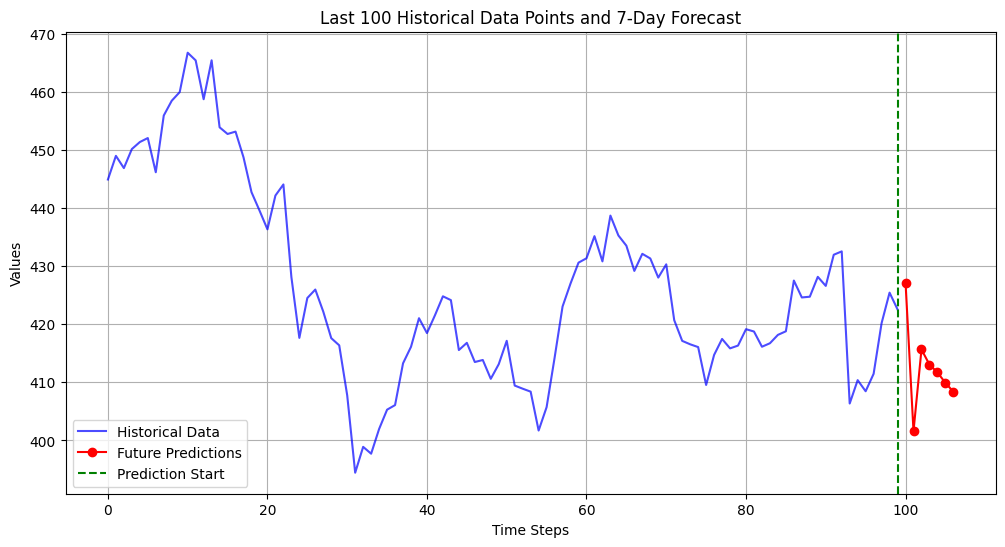

In [20]:
# Plot the last 100 historical data points and future predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(historical_data[-100:])), historical_data[-100:], label='Historical Data', color='blue', alpha=0.7)
adjusted_future_time_steps = range(len(historical_data[-100:]), len(historical_data[-100:]) + len(future_time_steps))
plt.plot(adjusted_future_time_steps, future_predictions, label='Future Predictions', color='red', marker='o')
plt.axvline(x=len(historical_data[-100:]) - 1, color='green', linestyle='--', label='Prediction Start')
plt.title("Last 100 Historical Data Points and 7-Day Forecast")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.grid()

# Show the plot
plt.show()
